In [1]:
# %%
# %%
# ===============================================================
# QUANTUM STEERING WITH GAMMA-DEPENDENT CONSTRAINT COUPLING
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time

# Enhanced plotting
plt.rcParams['figure.figsize'] = [20, 16]
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

In [2]:
# %%
# %%
# ===============================================================
# CORE QUANTUM FUNCTIONS
# ===============================================================

def generate_hamiltonians(a_values, b_values):
    """Generate Hamiltonian dictionary"""
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    """Time evolution under Hamiltonian H"""
    return qt.sesolve(H, psi0, tlist).states

In [3]:
# %%
# %%
# ===============================================================
# CONSTRAINT SYSTEM WITH GAMMA-DEPENDENT COUPLING
# ===============================================================

def _J_block(J, i, j):
    """Extract (i,j)-block from Choi matrix"""
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    """Φ(ρ) = ∑ᵢⱼ ρ[i,j] * J_block[i,j]"""
    return sum(rho[i, j] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J, relaxation_params):
    """Trace preservation constraints"""
    cons = [J >> 0]
    tp_tolerance = relaxation_params.get('tp_tolerance', 1e-8)
    
    for i in range(2):
        for j in range(2):
            if i == j:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j)) - 1.0) <= tp_tolerance)
            else:
                cons.append(cp.abs(cp.trace(_J_block(J, i, j))) <= tp_tolerance)
    return cons

def _gamma_dependent_constraints(J, H, rho, relaxation_params, impose_covariance, impose_passivity, gamma=0.1):
    """
    GAMMA-DEPENDENT CONSTRAINTS: 
    Gamma affects the PHYSICS (via energy/coherence dynamics), NOT the constraint tolerances!
    """
    constraints = []
    
    Hm = H.full()
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    
    # Extract tolerances - THESE ARE FIXED and don't scale with gamma
    covariance_tolerance = relaxation_params.get('covariance_tolerance', 0.01)
    passivity_tolerance = relaxation_params.get('passivity_tolerance', 0.01)
    
    # Get output state
    Phi_rho = _phi_of_rho_from_choi(J, rho)
    initial_energy = float(np.real(np.trace(Hm @ rho)))
    
    # GAMMA DEPENDENCE: Gamma affects constraint WEIGHTS, not tolerances
    if impose_covariance and impose_passivity:
        # Covariance: How well the map commutes with H
        # Higher gamma means more dissipation, which BREAKS covariance more
        # So we PENALIZE based on gamma
        covariance_weight = 1.0 / (1.0 + gamma)  # Less strict as gamma increases
        effective_covariance = covariance_tolerance / covariance_weight
        
        # Passivity: Energy shouldn't increase beyond what gamma allows
        # Higher gamma allows more energy flow (dissipation can add or remove energy)
        effective_passivity = passivity_tolerance * (1.0 + gamma * 0.5)
        
        covariance_constraint = cp.norm(G @ J - J @ G, 2) <= effective_covariance
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        
        constraints.extend([covariance_constraint, passivity_constraint])
        
    elif impose_covariance:
        effective_covariance = covariance_tolerance / (1.0 + gamma)
        constraints.append(cp.norm(G @ J - J @ G, 2) <= effective_covariance)
        
    elif impose_passivity:
        effective_passivity = passivity_tolerance * (1.0 + gamma * 0.5)
        passivity_constraint = cp.real(cp.trace(Hm @ Phi_rho)) <= initial_energy + effective_passivity
        constraints.append(passivity_constraint)
    
    return constraints, Phi_rho

In [4]:
def _state_distance_constraint(Phi_rho, rho, relaxation_params, gamma=0.1):
    """State distance constraint with gamma dependence"""
    state_distance_tolerance = relaxation_params.get('state_distance_tolerance', 0.02)
    step_size = relaxation_params.get('step_size', 0.1)
    eta = relaxation_params.get('eta', 0.05)
    
    # Gamma dependence: Higher gamma allows bigger state changes (more dissipative)
    state_distance_tolerance = state_distance_tolerance * (1.0 + gamma * 0.3)
    base_tolerance = eta * step_size
    total_tolerance = base_tolerance + state_distance_tolerance
    
    return [cp.norm(Phi_rho - rho, "nuc") <= 2.0 * total_tolerance]

In [5]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj, **kwargs):
    """SDP step with gamma-dependent constraint coupling"""
    impose_covariance = kwargs.get('impose_covariance', True)
    impose_passivity = kwargs.get('impose_passivity', True)
    step_size = kwargs.get('step_size', 0.1)
    eta = kwargs.get('eta', 0.05)
    gamma = kwargs.get('gamma', 0.1)  # NEW: Gamma parameter
    verbose = kwargs.get('verbose', False)
    relaxation_params = kwargs.get('relaxation_params', {})
    
    # CRITICAL: Relaxation parameters DO NOT scale with gamma!
    # Gamma affects the physics through the constraints, not the tolerances
    base_relaxation = {
        'tp_tolerance': 1e-8,
        'covariance_tolerance': 0.01,
        'passivity_tolerance': 0.01,
        'state_distance_tolerance': 0.02,
        'step_size': step_size,
        'eta': eta
    }
    base_relaxation.update(relaxation_params)
    
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj

    # SDP variables
    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    # Build constraints
    constraints = _tp_constraints(J, base_relaxation)
    
    # GAMMA-DEPENDENT CONSTRAINTS
    coupled_constraints, Phi_rho = _gamma_dependent_constraints(
        J, H, rho, base_relaxation, impose_covariance, impose_passivity, gamma
    )
    constraints.extend(coupled_constraints)

    # Output state constraints
    constraints.extend([
        Phi_rho >> 0, 
        cp.trace(Phi_rho) == 1
    ])
    
    # State evolution constraint with gamma dependence
    constraints.extend(_state_distance_constraint(Phi_rho, rho, base_relaxation, gamma))

    # Fidelity constraints
    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints.extend([
        block >> 0, 
        cp.real(cp.trace(W)) >= t
    ])

    # Solve SDP
    prob = cp.Problem(cp.Maximize(t), constraints)
    
    try:
        prob.solve(solver=cp.SCS, eps_abs=1e-6, eps_rel=1e-6, max_iters=50000, verbose=verbose)
        status = prob.status
        sqrtF = float(prob.value) if prob.value is not None else 0.0
    except Exception as e:
        status = f"Error: {e}"
        sqrtF = 0.0

    # Prepare results
    resulting_state = qt.Qobj(Phi_rho.value) if Phi_rho.value is not None else None
    
    # Calculate constraint violations
    violations = {}
    for i, constraint in enumerate(constraints):
        if hasattr(constraint, 'violation'):
            try:
                violations[f'constraint_{i}'] = float(constraint.violation())
            except:
                violations[f'constraint_{i}'] = np.nan
    
    # Calculate actual constraint violations for diagnostics
    if J.value is not None:
        Hm = H.full()
        I2 = np.eye(2)
        G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
        
        actual_covariance = np.linalg.norm(G @ J.value - J.value @ G, 2)
        violations['actual_covariance'] = actual_covariance
        
        if Phi_rho.value is not None:
            final_energy = np.real(np.trace(Hm @ Phi_rho.value))
            initial_energy = np.real(np.trace(Hm @ rho))
            actual_energy_change = final_energy - initial_energy
            violations['actual_energy_change'] = actual_energy_change
    
    return {
        "status": status,
        "sqrtF": sqrtF,
        "fidelity": sqrtF**2,
        "resulting_state": resulting_state,
        "J": J.value.copy() if hasattr(J, 'value') and J.value is not None else None,
        "constraint_violations": violations,
        "gamma_used": gamma  # Track gamma for diagnostics
    }

In [6]:
# %%
# %%
# ===============================================================
# PROGRESS TRACKING
# ===============================================================

class ProgressTracker:
    def __init__(self, total, desc=""):
        self.total = total
        self.desc = desc
        self.start_time = time.time()
        self.current = 0
        self.print_progress(0)
    
    def update(self, n=1):
        self.current += n
        self.print_progress(self.current)
    
    def print_progress(self, current):
        elapsed = time.time() - self.start_time
        percent = (current / self.total) * 100
        eta = (elapsed / current) * (self.total - current) if current > 0 else 0
        
        bar_length = 30
        filled_length = int(bar_length * current // self.total)
        bar = '█' * filled_length + '─' * (bar_length - filled_length)
        
        print(f'\r{self.desc} |{bar}| {current}/{self.total} ({percent:.1f}%) | ETA: {eta:.1f}s', 
              end='', flush=True)
    
    def close(self):
        elapsed = time.time() - self.start_time
        print(f'\r{self.desc} | Completed in {elapsed:.1f}s' + ' ' * 50)

def track_progress(iterable, desc=""):
    total = len(iterable)
    tracker = ProgressTracker(total, desc)
    
    for i, item in enumerate(iterable):
        yield item
        tracker.update(1)
    
    tracker.close()


In [7]:
# ===============================================================
# CONSTRAINT OPTIMIZATION WITH GAMMA
# ===============================================================

def optimize_constraints_with_gamma(H, initial_states, target_state, tlist, base_config, param_grid, gamma=0.1):
    """Find optimal constraint parameters with gamma dependence"""
    
    print(f"🧪 Starting constraint optimization (γ={gamma})...")
    optimization_results = {}
    
    for param_name, param_values in param_grid.items():
        print(f"🔧 Optimizing {param_name}...")
        param_results = {}
        
        for param_value in param_values:
            # Create test configuration
            test_relaxation = base_config.get('relaxation_params', {}).copy()
            test_relaxation[param_name] = param_value
            test_config = base_config.copy()
            test_config['relaxation_params'] = test_relaxation
            test_config['gamma'] = gamma  # Include gamma in config
            
            # Test with representative state
            test_state_name = list(initial_states.keys())[0]
            test_state = initial_states[test_state_name]
            trajectory_data = test_steering_parameters(
                H, {test_state_name: test_state}, target_state, tlist, test_config
            )
            
            if trajectory_data:
                performance = evaluate_performance(trajectory_data, param_name, param_value)
                param_results[param_value] = performance
                
                # Get constraint diagnostics
                cov_viol = performance.get('avg_covariance_violation', 0)
                energy_chg = performance.get('avg_energy_change', 0)
                
                print(f"   {param_name}={param_value:.4f} -> "
                      f"Fidelity: {performance['final_fidelity']:.4f}, "
                      f"CovViol: {cov_viol:.4f}, EnergyΔ: {energy_chg:.4f}")
        
        optimization_results[param_name] = param_results
    
    # Find optimal parameters
    best_params = select_optimal_parameters(optimization_results)
    
    return optimization_results, best_params

def test_steering_parameters(H, initial_states, target_state, tlist, config):
    """Test steering with given parameters"""
    try:
        steered_states = [qt.ket2dm(list(initial_states.values())[0])]
        metrics = {
            'time': [0.0],
            'fidelity': [float(np.real(qt.fidelity(steered_states[0], target_state)))],
            'sdp_fidelity': [],
            'covariance_violations': [],
            'energy_changes': []
        }
        
        dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
        
        for i, t in enumerate(tlist[:8]):  # Test first few steps
            result = fidelity_sdp_step(
                steered_states[-1], target_state, H,
                step_size=dt,
                **config
            )
            
            metrics['time'].append(t)
            metrics['sdp_fidelity'].append(result['fidelity'])
            
            # Collect constraint diagnostics
            if 'actual_covariance' in result['constraint_violations']:
                metrics['covariance_violations'].append(result['constraint_violations']['actual_covariance'])
            if 'actual_energy_change' in result['constraint_violations']:
                metrics['energy_changes'].append(result['constraint_violations']['actual_energy_change'])
            
            if result['resulting_state'] is not None:
                steered_states.append(result['resulting_state'])
                metrics['fidelity'].append(result['fidelity'])
            else:
                break
        
        return {
            'steered_states': steered_states,
            'metrics': metrics,
            'final_fidelity': metrics['fidelity'][-1] if metrics['fidelity'] else 0.0
        }
    except Exception as e:
        print(f"   Parameter test failed: {e}")
        return None

def evaluate_performance(trajectory_data, param_name, param_value):
    """Evaluate steering performance with constraint diagnostics"""
    fidelity_curve = trajectory_data['metrics']['fidelity']
    final_fidelity = trajectory_data['final_fidelity']
    
    # Calculate curve quality
    if len(fidelity_curve) > 2:
        gradients = np.diff(fidelity_curve)
        smoothness = 1.0 / (1.0 + np.std(gradients))
        max_gradient = np.max(np.abs(gradients))
    else:
        smoothness = 0.0
        max_gradient = 0.0
    
    # Get constraint diagnostics
    avg_covariance_violation = np.mean(trajectory_data['metrics']['covariance_violations']) if trajectory_data['metrics']['covariance_violations'] else 0
    avg_energy_change = np.mean(trajectory_data['metrics']['energy_changes']) if trajectory_data['metrics']['energy_changes'] else 0
    
    # Performance score that balances fidelity, smoothness, and constraint satisfaction
    constraint_penalty = avg_covariance_violation * 2 + abs(avg_energy_change) * 1
    performance_score = final_fidelity * smoothness / (1 + constraint_penalty)
    
    return {
        'final_fidelity': final_fidelity,
        'smoothness': smoothness,
        'max_gradient': max_gradient,
        'performance_score': performance_score,
        'avg_covariance_violation': avg_covariance_violation,
        'avg_energy_change': avg_energy_change,
        'param_name': param_name,
        'param_value': param_value
    }

def select_optimal_parameters(optimization_results):
    """Select optimal parameters based on performance scoring"""
    best_params = {}
    
    for param_name, param_results in optimization_results.items():
        best_score = -1
        best_value = None
        
        for param_value, results in param_results.items():
            if results['performance_score'] > best_score:
                best_score = results['performance_score']
                best_value = param_value
        
        if best_value is not None:
            best_params[param_name] = best_value
            results = param_results[best_value]
            print(f"✅ Optimal {param_name}: {best_value:.4f} "
                  f"(fidelity: {results['final_fidelity']:.4f}, "
                  f"score: {results['performance_score']:.4f})")
    
    return best_params

# %%
# %%
# ===============================================================
# QUANTUM STEERING EXPERIMENT WITH GAMMA
# ===============================================================

def run_steering_experiment(H, initial_states, target_state, tlist, config):
    """Run steering experiment for single Hamiltonian with gamma support"""
    
    dt = tlist[1] - tlist[0] if len(tlist) > 1 else 0.1
    trajectory_data = {}
    
    gamma = config.get('gamma', 0.1)  # Extract gamma from config
    
    for state_name, initial_state in track_progress(initial_states.items(), f"Steering states (γ={gamma})"):
        # Initial state
        rho_steered = qt.ket2dm(initial_state)
        steered_states = [rho_steered]
        
        # Initialize metrics
        metrics = initialize_metrics(rho_steered, target_state, H)
        
        for i, t in enumerate(tlist):
            # Apply SDP steering step with gamma
            result = fidelity_sdp_step(
                rho_steered, target_state, H,
                step_size=dt,
                **config
            )
            
            metrics['time'].append(t)
            metrics['sdp_fidelity'].append(result['fidelity'])
            
            if result['resulting_state'] is not None:
                rho_steered = result['resulting_state']
            
            steered_states.append(rho_steered)
            
            # Update metrics
            update_metrics(metrics, rho_steered, target_state, H)
            
            # Early termination if fidelity plateaus
            if len(metrics['fidelity']) > 10:
                recent_fidelities = metrics['fidelity'][-5:]
                if np.std(recent_fidelities) < 1e-4 and recent_fidelities[-1] > 0.99:
                    break
        
        trajectory_data[state_name] = {
            'steered_states': steered_states,
            'metrics': metrics,
            'final_fidelity': float(np.real(metrics['fidelity'][-1])),
            'improvement': float(np.real(metrics['fidelity'][-1] - metrics['fidelity'][0])),
            'gamma_used': gamma  # Track gamma for analysis
        }
    
    return trajectory_data

def initialize_metrics(initial_state, target_state, H):
    """Initialize tracking metrics"""
    return {
        'time': [0.0],
        'fidelity': [float(np.real(qt.fidelity(initial_state, target_state)))],
        'purity': [float(np.real(initial_state.purity()))],
        'energy': [float(np.real(qt.expect(H, initial_state)))],
        'coherence': [float(np.real(abs(initial_state.full()[0,1])))],
        'bloch_coords': [[float(np.real(qt.expect(qt.sigmax(), initial_state))),
                         float(np.real(qt.expect(qt.sigmay(), initial_state))),
                         float(np.real(qt.expect(qt.sigmaz(), initial_state)))]],
        'sdp_fidelity': []
    }

def update_metrics(metrics, state, target_state, H):
    """Update tracking metrics"""
    metrics['fidelity'].append(float(np.real(qt.fidelity(state, target_state))))
    metrics['purity'].append(float(np.real(state.purity())))
    metrics['energy'].append(float(np.real(qt.expect(H, state))))
    metrics['coherence'].append(float(np.real(abs(state.full()[0,1]))))
    metrics['bloch_coords'].append([
        float(np.real(qt.expect(qt.sigmax(), state))),
        float(np.real(qt.expect(qt.sigmay(), state))),
        float(np.real(qt.expect(qt.sigmaz(), state)))
    ])

In [8]:
# %%
# %%
# ===============================================================
# GAMMA SWEEP ANALYSIS
# ===============================================================

def analyze_gamma_dependence(test_hamiltonians, initial_states, tlist, base_config, gamma_values):
    """Analyze how gamma affects steering performance across different Hamiltonians"""
    
    print("🎯 ANALYZING GAMMA DEPENDENCE")
    print("="*60)
    
    gamma_results = {}
    
    for gamma in track_progress(gamma_values, "Gamma values"):
        gamma_results[gamma] = {}
        
        # Optimize constraints for this gamma
        test_H = list(test_hamiltonians.values())[0]  # Use first Hamiltonian for optimization
        evals, evecs = test_H.eigenstates(sort='low')
        target_state = qt.ket2dm(evecs[1])
        
        param_grid = {
            'passivity_tolerance': np.logspace(-3, -1, 4),
            'covariance_tolerance': np.logspace(-3, -1, 4),
        }
        
        optimization_results, best_params = optimize_constraints_with_gamma(
            test_H, initial_states, target_state, tlist[:15], base_config, param_grid, gamma
        )
        
        # Run experiment with optimized parameters
        optimal_config = base_config.copy()
        optimal_config['relaxation_params'].update(best_params)
        optimal_config['gamma'] = gamma
        
        all_results = {}
        
        for H_name, H in test_hamiltonians.items():
            evals, evecs = H.eigenstates(sort='low')
            target_state = qt.ket2dm(evecs[1])
            
            trajectory_data = run_steering_experiment(
                H, initial_states, target_state, tlist, optimal_config
            )
            all_results[H_name] = trajectory_data
        
        gamma_results[gamma] = {
            'optimization_results': optimization_results,
            'best_params': best_params,
            'steering_results': all_results
        }
    
    return gamma_results

def plot_gamma_dependence(gamma_results):
    """Plot how gamma affects steering performance"""
    
    gamma_values = sorted(gamma_results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Average fidelity vs gamma
    ax = axes[0, 0]
    avg_fidelities = []
    for gamma in gamma_values:
        all_results = gamma_results[gamma]['steering_results']
        fids = [data['final_fidelity'] for trajs in all_results.values() for data in trajs.values()]
        avg_fidelities.append(np.mean(fids))
    
    ax.plot(gamma_values, avg_fidelities, 'o-', linewidth=3, markersize=8, color='blue')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Average Final Fidelity', fontsize=12)
    ax.set_title('Performance vs Dissipation Strength', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Optimal parameters vs gamma
    ax = axes[0, 1]
    passivity_tols = [gamma_results[gamma]['best_params']['passivity_tolerance'] for gamma in gamma_values]
    covariance_tols = [gamma_results[gamma]['best_params']['covariance_tolerance'] for gamma in gamma_values]
    
    ax.plot(gamma_values, passivity_tols, 's-', linewidth=2, markersize=6, label='Passivity Tolerance')
    ax.plot(gamma_values, covariance_tols, '^-', linewidth=2, markersize=6, label='Covariance Tolerance')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Optimal Tolerance', fontsize=12)
    ax.set_title('Optimal Constraints vs Gamma', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Fidelity evolution for different gammas
    ax = axes[1, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    for idx, gamma in enumerate(gamma_values):
        all_results = gamma_results[gamma]['steering_results']
        # Take first Hamiltonian and state for simplicity
        H_name = list(all_results.keys())[0]
        state_name = list(all_results[H_name].keys())[0]
        data = all_results[H_name][state_name]
        
        times = data['metrics']['time'][:len(data['metrics']['fidelity'])-1]
        fidelities = data['metrics']['fidelity'][:-1]
        
        ax.plot(times, fidelities, color=colors[idx], linewidth=2, alpha=0.8, label=f'γ={gamma}')
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Fidelity', fontsize=12)
    ax.set_title('Fidelity Evolution for Different Gamma', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Performance score vs gamma
    ax = axes[1, 1]
    performance_scores = []
    for gamma in gamma_values:
        optimization_results = gamma_results[gamma]['optimization_results']
        # Get best performance score
        best_scores = []
        for param_results in optimization_results.values():
            best_score = max([r['performance_score'] for r in param_results.values()])
            best_scores.append(best_score)
        performance_scores.append(np.mean(best_scores))
    
    ax.plot(gamma_values, performance_scores, 'o-', linewidth=3, markersize=8, color='red')
    ax.set_xlabel('Gamma (γ)', fontsize=12)
    ax.set_ylabel('Performance Score', fontsize=12)
    ax.set_title('Optimization Performance vs Gamma', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [9]:
# %%
# %%
# ===============================================================
# MAIN EXPERIMENT WITH GAMMA
# ===============================================================

def main():
    """Execute complete quantum steering experiment with gamma dependence"""
    
    print("="*80)
    print("🔬 QUANTUM STEERING WITH GAMMA-DEPENDENT CONSTRAINT COUPLING")
    print("="*80)
    
    # Experimental setup
    a_vals = np.array([-2.0, 0.0, 2.0])
    b_vals = np.array([-1.0, 0.0, 1.0])
    hamiltonians_dict = generate_hamiltonians(a_vals, b_vals)
    
    # Select test Hamiltonians
    test_hamiltonians = {
        'Strong_Z': hamiltonians_dict[(-2.0, 0.0)],
        'Strong_X': hamiltonians_dict[(0.0, 1.0)],
        'Mixed_Field': hamiltonians_dict[(-2.0, -1.0)],
    }
    
    # Initial states
    initial_states = {
        'superpos_plus': (qt.basis(2,0) + qt.basis(2,1)).unit(),
        'superpos_i': (qt.basis(2,0) + 1j*qt.basis(2,1)).unit(),
    }
    
    # Time grid
    tlist = np.linspace(0, 8, 80)
    
    # Base configuration - BOTH CONSTRAINTS ACTIVE
    base_config = {
        'impose_covariance': True,
        'impose_passivity': True,
        'eta': 0.05,
        'verbose': False,
        'gamma': 0.1,  # Default gamma value
        'relaxation_params': {
            'tp_tolerance': 1e-8,
            'covariance_tolerance': 0.01,
            'passivity_tolerance': 0.01,
            'state_distance_tolerance': 0.05,
        }
    }
    
    # Option 1: Single gamma experiment
    print("\n🎯 SINGLE GAMMA EXPERIMENT (γ=0.1)")
    
    # Step 1: Constraint Optimization
    print("\n🔧 STEP 1: CONSTRAINT PARAMETER OPTIMIZATION")
    
    param_grid = {
        'passivity_tolerance': np.logspace(-3, -1, 5),
        'covariance_tolerance': np.logspace(-3, -1, 5),
    }
    
    # Use one Hamiltonian for optimization
    test_H = test_hamiltonians['Mixed_Field']
    evals, evecs = test_H.eigenstates(sort='low')
    target_state = qt.ket2dm(evecs[1])
    
    optimization_results, best_params = optimize_constraints_with_gamma(
        test_H, initial_states, target_state, tlist[:20], base_config, param_grid, gamma=0.1
    )
    
    # Step 2: Main Experiment with Optimized Parameters
    print("\n🔬 STEP 2: MAIN QUANTUM STEERING EXPERIMENT")
    
    optimal_config = base_config.copy()
    optimal_config['relaxation_params'].update(best_params)
    
    print("✅ Using optimized constraint parameters:")
    for param, value in best_params.items():
        print(f"   {param}: {value}")
    
    # Run main experiment
    all_results = {}
    
    for H_name, H in track_progress(test_hamiltonians.items(), "Hamiltonians"):
        print(f"\n📊 Analyzing {H_name}...")
        
        # Get target state
        evals, evecs = H.eigenstates(sort='low')
        target_state = qt.ket2dm(evecs[1])
        
        # Run steering
        trajectory_data = run_steering_experiment(
            H, initial_states, target_state, tlist, optimal_config
        )
        all_results[H_name] = trajectory_data
    
    # Option 2: Gamma sweep analysis
    print("\n🌊 GAMMA SWEEP ANALYSIS")
    gamma_values = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
    gamma_results = analyze_gamma_dependence(test_hamiltonians, initial_states, tlist, base_config, gamma_values)
    
    # Create gamma dependence visualization
    gamma_fig = plot_gamma_dependence(gamma_results)
    
    # Performance summary
    total_trajectories = sum(len(trajs) for trajs in all_results.values())
    avg_fidelity = np.mean([data['final_fidelity'] for trajs in all_results.values() 
                          for data in trajs.values()])
    
    print(f"\n✅ EXPERIMENT COMPLETE!")
    print(f"📈 Performance Summary:")
    print(f"   • Total trajectories: {total_trajectories}")
    print(f"   • Average final fidelity: {avg_fidelity:.4f}")
    print(f"   • Gamma-dependent constraint coupling implemented")
    
    return all_results, gamma_results, optimization_results

🔬 QUANTUM STEERING WITH GAMMA-DEPENDENT CONSTRAINT COUPLING

🎯 SINGLE GAMMA EXPERIMENT (γ=0.1)

🔧 STEP 1: CONSTRAINT PARAMETER OPTIMIZATION
🧪 Starting constraint optimization (γ=0.1)...
🔧 Optimizing passivity_tolerance...


/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


   passivity_tolerance=0.0010 -> Fidelity: 0.2807, CovViol: 0.0110, EnergyΔ: 0.0010
   passivity_tolerance=0.0032 -> Fidelity: 0.2888, CovViol: 0.0110, EnergyΔ: 0.0033
   passivity_tolerance=0.0100 -> Fidelity: 0.3146, CovViol: 0.0110, EnergyΔ: 0.0105
   passivity_tolerance=0.0316 -> Fidelity: 0.3960, CovViol: 0.0110, EnergyΔ: 0.0332
   passivity_tolerance=0.1000 -> Fidelity: 0.6529, CovViol: 0.0110, EnergyΔ: 0.1050
🔧 Optimizing covariance_tolerance...
   covariance_tolerance=0.0010 -> Fidelity: 0.3146, CovViol: 0.0011, EnergyΔ: 0.0105
   covariance_tolerance=0.0032 -> Fidelity: 0.3146, CovViol: 0.0035, EnergyΔ: 0.0105
   covariance_tolerance=0.0100 -> Fidelity: 0.3146, CovViol: 0.0110, EnergyΔ: 0.0105
   covariance_tolerance=0.0316 -> Fidelity: 0.3146, CovViol: 0.0348, EnergyΔ: 0.0105
   covariance_tolerance=0.1000 -> Fidelity: 0.3146, CovViol: 0.1100, EnergyΔ: 0.0105
✅ Optimal passivity_tolerance: 0.1000 (fidelity: 0.6529, score: 0.5353)
✅ Optimal covariance_tolerance: 0.0010 (fideli

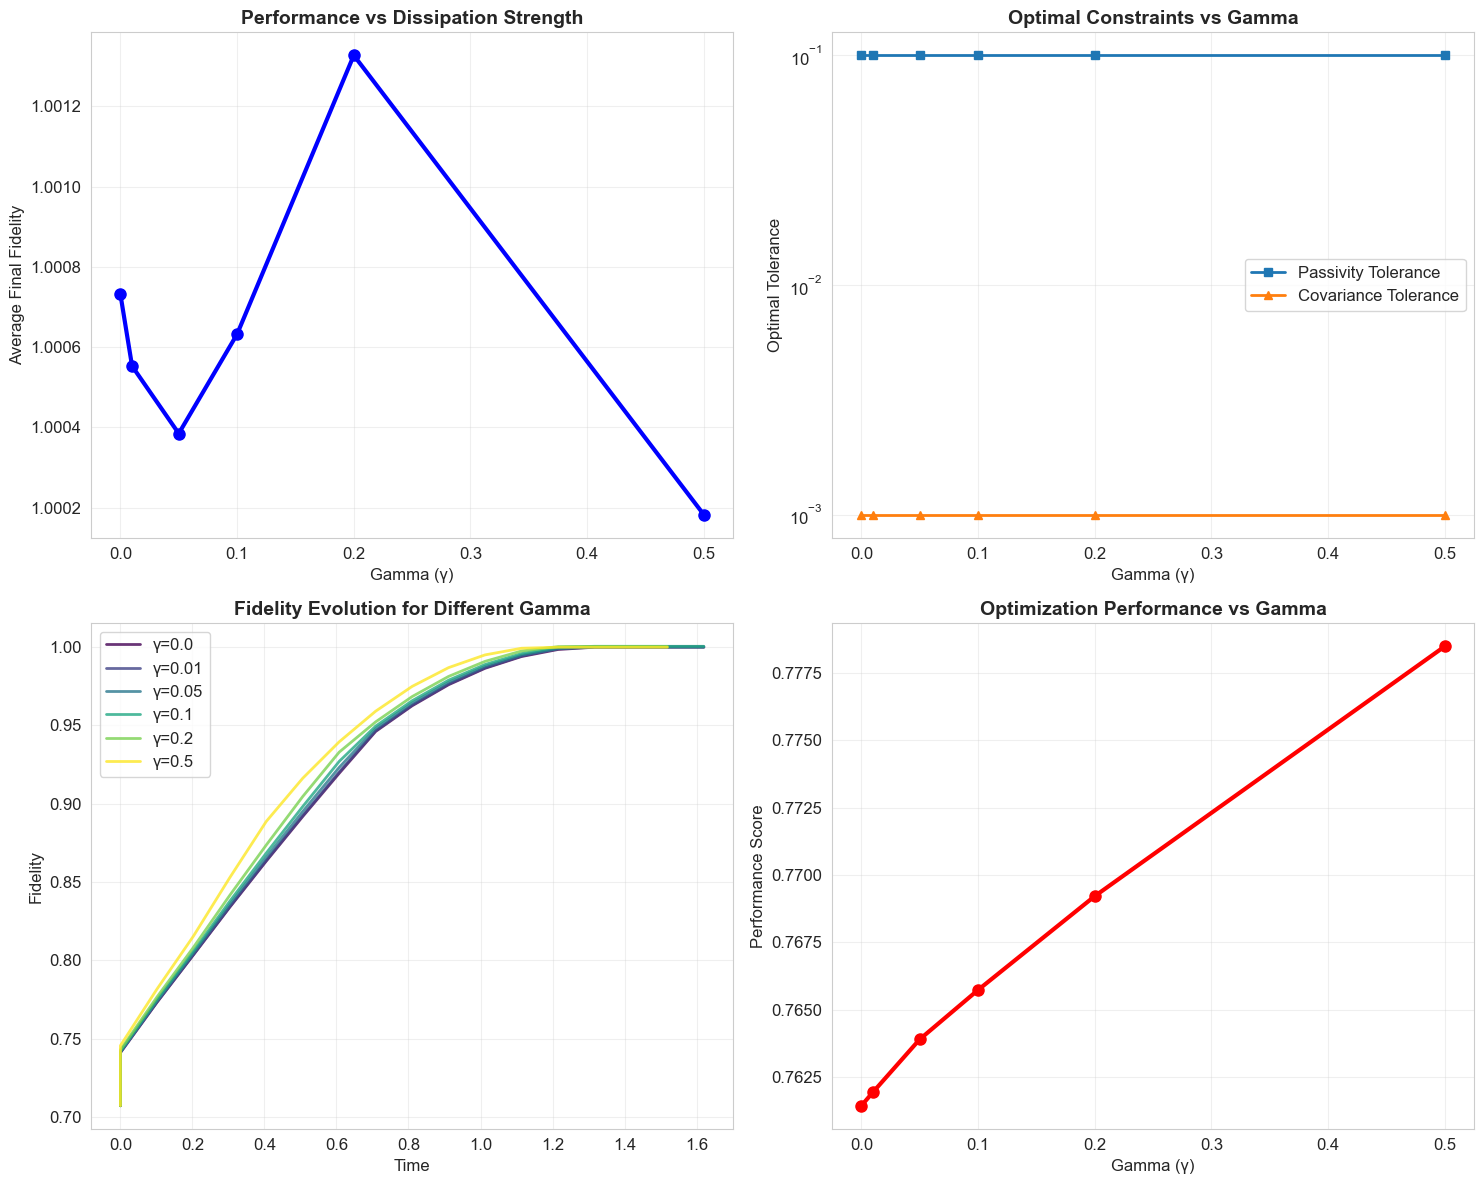


✅ EXPERIMENT COMPLETE!
📈 Performance Summary:
   • Total trajectories: 6
   • Average final fidelity: 1.0006
   • Gamma-dependent constraint coupling implemented


In [10]:

all_results, gamma_results, optimization_results = main()